# Impact of path on spectral features in an offline DA product: the Last Millennium Reanalysis 

In [1]:
%load_ext autoreload
%autoreload 2
# import the pens package (https://github.com/fzhu2e/pens)
import pens

## Load LMR 2.1 data from a local .nc file

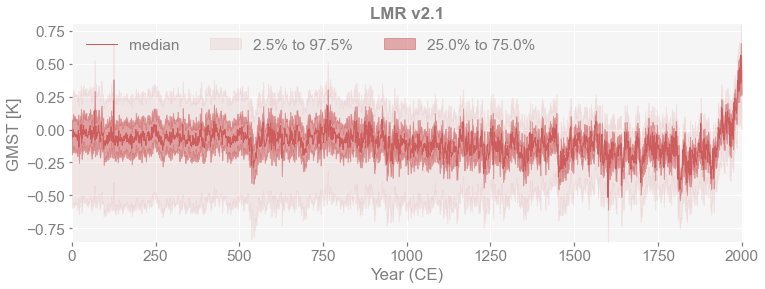

In [2]:
folder = '/Users/julieneg/Documents/Science/Research/LastMillenniumReanalysis/data/LMRv2.1/'
ens = pens.EnsembleTS().load_nc(folder + 'gmt_MCruns_ensemble_full_LMRv2.1.nc', var='gmt')
fig, ax = ens.plot_qs(ylabel='GMST [K]', title='LMR v2.1')

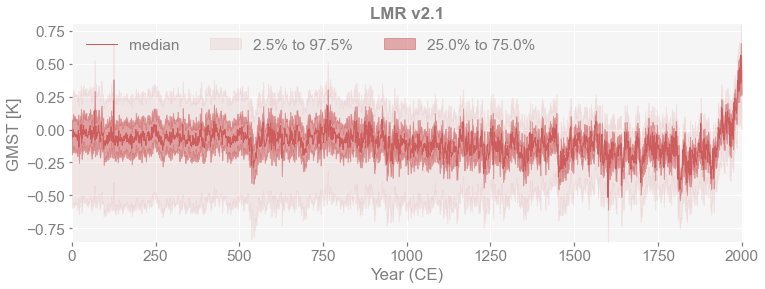

## Get and plot random sample paths from the ensembles

(2001, 1)
(2001, 3)


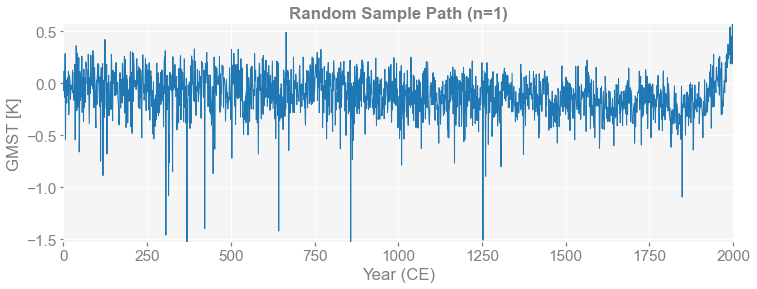

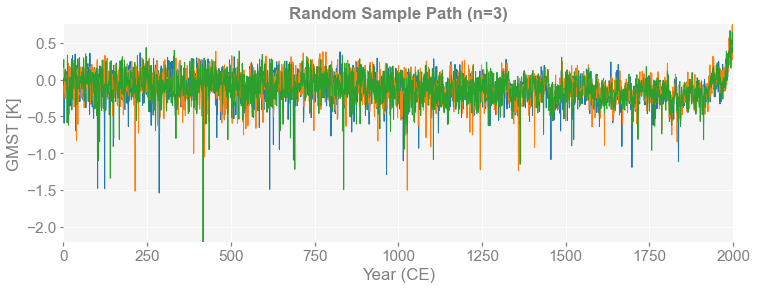

In [3]:
for n in [1, 3]:
    ps = ens.sample_random(n=n, seed=2333)
    fig, ax = ps.plot(ylabel='GMST [K]', title=f'Random Sample Path (n={n})')
    print(ps.value.shape)

Obviously, sampling from this ensemble will change the assessment of the timing of certain events (e.g. extreme cooling) in a given series, though the distribution is invariant.  How does this affect the estimation of spectral features?


## Impact on spectral features: peaks and continuum

We will convert the series to a pyleoclim [EnsembleSeries object](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#ensembleseries-pyleoclim-ensembleseries) to easily estimate spectra.

First, we do so on the original ensemble members, then we repeat the analysis on the randomized paths. 

### Original Ensemble

In [4]:
es_orig = ens.to_pyleo()  
PSD_orig = es_orig.spectral(method='mtm') # this generate a MultiplePSD object

Performing spectral analysis on individual series: 100%|█████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.91it/s]


<AxesSubplot:title={'center':'Spectral density of LMR2.1 GMST'}, xlabel='Period', ylabel='PSD'>

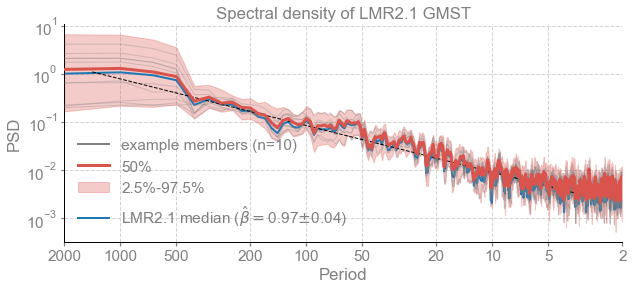

In [10]:
fig, ax = PSD_orig.plot_envelope(title="Spectral density of LMR2.1 GMST, original ensemble")
esm = ens.get_median() # extract and analyze the ensemble median
esm = esm.to_pyleo(label='LMR2.1 median')
esm_spec = esm.spectral(method ='mtm')
esm_beta = esm_spec.beta_est() # estimate spectral exponent
esm_beta.plot(ax=ax)

Comments here ...

Now for the randomized paths

In [9]:
nens = ens.value.shape[1]
ps_rnd = ens.sample_random(n=nens, seed=2333)
es_rnd = ps_rnd.to_pyleo() # resample while preserving ensemble size
PSD_rnd = es_rnd.spectral(method='mtm')

Performing spectral analysis on individual series: 100%|█████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.29it/s]


Let's plot it:

<AxesSubplot:title={'center':'Spectral density of LMR2.1 GMST, randomized paths'}, xlabel='Period', ylabel='PSD'>

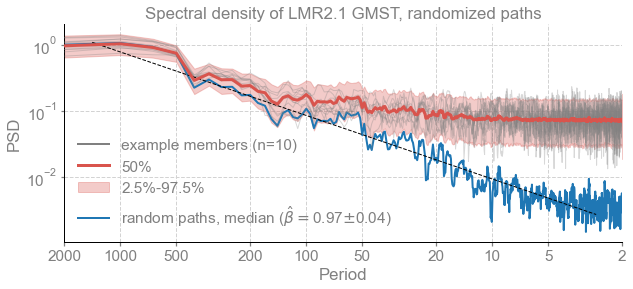

In [12]:
fig, ax = PSD_rnd.plot_envelope(title="Spectral density of LMR2.1 GMST, randomized paths")
esm_rnd = ps_rnd.get_median() # extract and analyze the ensemble median
esm_rnd = esm_rnd.to_pyleo(label='random paths, median')
esm_rnd_spec = esm_rnd.spectral(method ='mtm')
esm_rnd_beta = esm_rnd_spec.beta_est() # estimate spectral exponent
esm_rnd_beta.plot(ax=ax)

We see that randomizing the paths has greatly affected the individual spectra, while leaving the median (blue curve) virtually untouched. That is because, in such a large ensemble, the median of the randomized ensemble converges to the median of the original ensemble (it may not be so in smaller ensembles, but we expect the effect to be negligible over 100 members or so). 

Another way to view this difference is in terms of variance:

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

var_median = esm.stats()['std']**2
var_orig = np.empty((nens))
var_rnd = np.empty((nens))
for i in range(nens):
    var_orig[i] = es_orig.series_list[i].stats()['std']**2
    var_rnd[i]  = es_rnd.series_list[i].stats()['std']**2

Text(0.5, 1.0, 'Effect on variance in LMRv2.1')

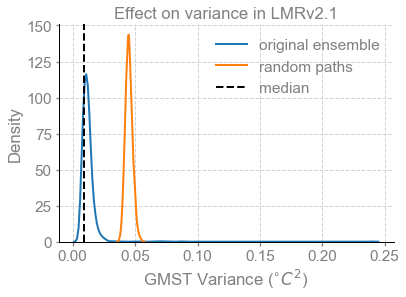

In [34]:
fig, ax = plt.subplots()
sns.kdeplot(var_orig,label='original ensemble',ax=ax) # plot their distribution
sns.kdeplot(var_rnd,label='random paths',ax=ax)
ax.axvline(x=var_median,ymin=0,ymax=150,ls='--',lw=2, color='black',label='median') # add the scaling exponent of the median trajectory
ax.legend()
ax.set_xlabel(r'GMST Variance (${{}^{\circ}C}^2$)')
ax.set_title('Effect on variance in LMRv2.1')

This is  also reflected in scaling exponents:

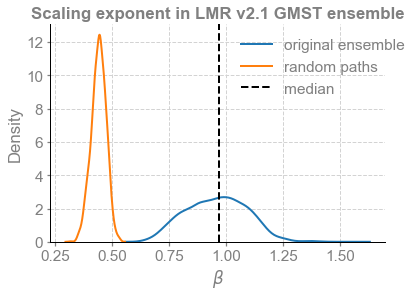

In [41]:
fig, ax = plt.subplots()
orig_beta = PSD_orig.beta_est() # estimate scaling exponents
rnd_beta = PSD_rnd.beta_est()
sns.kdeplot(orig_beta.beta_est_res['beta'],label='original ensemble',ax=ax) # plot their distribution
sns.kdeplot(rnd_beta.beta_est_res['beta'],label='random paths', ax=ax) # plot their distribution
ax.set_xlabel(r'$\beta$')
ax.set_title('Scaling exponent in LMR v2.1 GMST ensemble',fontweight='bold')
ax.axvline(x=esm_beta.beta_est_res['beta'],ymin=0,ymax=10,ls='--',lw=2, color='black',label='median') # add the scaling exponent of the median trajectory
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

Evidently, sampling from the ensemble has a great impact on the estimated spectral slope. It is expected that online DA would greatly mitigate this effect.